In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from scipy import signal
import csv
import os

In [23]:
def calculate_norms(df, normalize = True):
    
    '''
    Calculates the norm of the sensors along the X, Y and Z axis and returns the threshold based on the mean of the norms
    Parameters:
        df : Dataframe with the data
        normalize: Set to True to min-max normalize the total norm of the signals. This is used to distinguish periodic from exposive activities. Gives better performance
    Return:
        norms: dictionary with norms of the sensors along the X, Y and Z axis
        times: time vector of the recording
        thr: dictionary with thresholds of the signals
    '''
    
    cols = []
    for s in sensors:
        for bp in bodyparts:
            for a in axes:
                cols.append('{}{}{}'.format(bp,s,a))

    norm_all = np.linalg.norm(df[cols].values, ord = 2, axis=1)
    
    thr = 10
    if normalize:
        norm_all = (norm_all-min(norm_all))/(max(norm_all)-min(norm_all))
        thr = 0.12
        
    IQR = np.percentile(norm_all, 75)-np.percentile(norm_all, 25)
    
    if IQR < thr:
        coefficients_means = {'Acc': 1.5, 'Gyro': 1.5}
    else:
        coefficients_means = {'Acc': 1, 'Gyro': 1}
    
    norms = {}
    thr = {}
    for s in sensors:
        for bp in bodyparts:
            norms[bp+s] = np.linalg.norm(df[['{}{}X'.format(bp,s), '{}{}Y'.format(bp,s), '{}{}Z'.format(bp,s)]].values, 
                                         ord = 2, axis=1)
            thr[bp+s] = coefficients_means[s] * np.mean(norms[bp+s])  
    return norms, df['time'], thr

In [84]:
def times_activity(norms, thr, num_steps = 50):
    '''
    Calculates the initial and final times of the detected activity for each norm signal
    Parameters:
        norms: dictionary with norms of the sensors along the X, Y and Z axis
        thr: dictionary with thresholds of the signals
        num_steps: number of steps that the signal must be above the threshold to be considered the start or end of the activity
    Returns:
        initial: dictionary of initial time index for each sensor
        final: dictionary of final time index for each sensor
    '''
    
    initial = {}
    for k in norms:
        larger_than_thr = norms[k] > thr[k]
        for i in range(len(larger_than_thr)):
            if larger_than_thr[i]:
                if i + num_steps > len(larger_than_thr):
                    initial[k] = 0
                    break
                else:
                    if all(larger_than_thr[i:i+num_steps]):
                        initial[k] = i
                        break
    final = {}
    for k in norms:
        larger_than_thr = norms[k] > thr[k]
        for i in range(len(larger_than_thr)-1, -1, -1):
            if larger_than_thr[i]:
                if i - num_steps < 0:
                    final[k] = len(larger_than_thr)
                    break
                else:
                    if all(larger_than_thr[i-num_steps:i]):
                        final[k] = i
                        break
    
    return initial, final

In [25]:
def plot_initial_final_timeseries(norms, 
                    times,
                    thr = {},
                    initial = {},
                    final = {}, 
                    plot_thr = False):
    
    '''
    Plots each sensor with its respective initial and final detected time
    Parameters: 
        norms: dictionary with norms of the sensors along the X, Y and Z axis
        times: time vector of the recording
        thr: dictionary with thresholds of the signals
        initial: dictionary of initial time index for each sensor
        final: dictionary of final time index for each sensor
        plot_thr (boolean): whether to plot or not the thresholds for each signal
    '''
    
    for s in sensors:
        fig, axes = plt.subplots(nrows=len(bodyparts), ncols=1, figsize=(15,14))
        for i in range(len(bodyparts)):
            axes[i].plot(times, norms[bodyparts[i]+s], label = 'Norm {}'.format(bodyparts[i]+s))
            if plot_thr:
                axes[i].plot(times, [thr[bodyparts[i]+s]]*len(times), c='r', linestyle='--')
            if initial:
                axes[i].axvspan(times.iloc[0], times.iloc[initial[bodyparts[i]+s]], facecolor='0.2', alpha=0.5)
            if final:
                axes[i].axvspan(times.iloc[final[bodyparts[i]+s]], times.iloc[-1], facecolor='0.2', alpha=0.5)
        for ax in axes:
            ax.legend(loc='upper right')
            ax.yaxis.tick_left()
            ax.axes.get_xaxis().set_visible(False)
            ax.set_xlim(times.iloc[0], times.iloc[-1])

        axes[-1].axes.get_xaxis().set_visible(True)
        fig.subplots_adjust(hspace = 0)

In [26]:
def extract_activity(df, margin = 250, normalize = True, num_steps = 50):
    '''
    Extracts the cropped activity from a recording. Returns initial and final time indices 
    Parameters:
        df : Dataframe with the data
        margin: Number of samples to take before and after the start and end of the activity
        normalize: Set to True to min-max normalize the total norm of the signals. This is used to distinguish periodic from exposive activities. Gives better performance
        num_steps: number of samples that the signal must be above the threshold to be considered the start or end of the activity
    Returns:
        cropped_activity: cropped activity from a recording
        initial_total: initial time of the activity
        final_total: final time of the activity
    '''

    norms, times, thr = calculate_norms(df, normalize = normalize)

    initial, final = times_activity(norms, thr, num_steps = num_steps)

    initial_total = min(initial.values()) if initial.values() else 0
    final_total = max(final.values()) if final.values() else len(df)
    
    initial_total = 0 if initial_total - margin < 0 else initial_total - margin
    final_total = -1 if final_total + margin >= len(times) else final_total + margin
    
    return df.iloc[initial_total:final_total], initial_total, final_total

In [27]:
def extract_activities(in_dir, margin = 250, normalize = True, only_lengths = False, num_steps = 50, savefile = None):
    '''
    Extracts the cropped activities from all the files. Saves the initial and final time indices if savefile is set to the path of the file where they want to be saved
    Parameters:
        in_dir: directory where the csv files of the recordings are
        margin: Number of samples to take before and after the start and end of the activity
        normalize: Set to True to min-max normalize the total norm of the signals. This is used to distinguish periodic from exposive activities. Gives better performance
        only_lengths: If True, only samples_activities and times_activities are returned. extracted_activities will be an empty list
        num_steps: Number of samples that the signal must be above the threshold to be considered the start or end of the activity
        savefile: Path of the csv file where the initial and final time indices of each activity are saved. Set to None to not create this file
    Returns:
        extracted_activities: List with cropped dataframes
        samples_activities: List with number of samples of each cropped activity
        times_activities: List with number of seconds of each cropped activity
    '''

    files = glob.glob("{}*.csv".format(in_dir))
    
    samples_activities = []
    extracted_activities = []
    times_activities = []
    
    savelist = [['File', 'Initial time index of activity', 'Final time index of activity']]
    
    for i, file in enumerate(files):
        if i%100 == 0:
            print('{}/{}'.format(i, len(files)))
            
        df = pd.read_csv(file)
        extracted_activity, initial_time, final_time = extract_activity(df, margin = margin, normalize = normalize, num_steps = num_steps)
        if not only_lengths:
            extracted_activities.append(extracted_activity)

        samples_activities.append(len(extracted_activity))
        times_activities.append(extracted_activity['time'].iloc[-1] - extracted_activity['time'].iloc[0])
        
        if savefile:
            savelist.append([file, initial_time, final_time])
    
    print('Done')
    if savefile:
        with open(savefile, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(savelist)
        print('Initial and final times of activities saved in file {}'.format(savefile))
        
        
    return extracted_activities, samples_activities, times_activities   

In [28]:
def lengths_per_activity_from_file(in_dir, times_file):
    '''
    Creates dictionaries with numbers of samples and seconds per each activity. Uses info from times_file file
    Parameters:
        in_dir: folder where the csv files of the recordings are
        times_file: csv file with the initial and final time indices of the detected activities
    Returns:
        samples_per_activity: Dictionary in which each key is an activity and the respective value is a list of the number of samples for each recording of the activity
        times_per_activity: Dictionary in which each key is an activity and the respective value is a list of the seconds for each recording of the activity
    '''
    
    files = glob.glob("{}*.csv".format(in_dir))
    df_times = pd.read_csv(times_file)
    
    samples_per_activity = {}
    times_per_activity = {}
    
    for i, file in enumerate(files):
        if i%100 == 0:
            print('{}/{}'.format(i, len(files)))
            
        df = pd.read_csv(file)
        
        label = df['gen_label'].iloc[0]
        
        initial = df_times[df_times['File'] == file]['Initial time index of activity'].values[0]
        final = df_times[df_times['File'] == file]['Final time index of activity'].values[0]
    
        final = len(df)-1 if final == -1 else final
        t = df['time'].iloc[final] - df['time'].iloc[initial]
        
        samples_per_activity.setdefault(label,[final-initial]).append(final-initial)
        times_per_activity.setdefault(label,[t]).append(t)
        
    print('Done')

    return samples_per_activity, times_per_activity

In [29]:
def lengths_per_activity(in_dir, samples_activities, times_activities):
    
    '''
    Creates dictionaries with numbers of samples and seconds per each activity:
    Parameters:
        samples_activities: List with number of samples of each cropped activity
        times_activities: List with number of seconds of each cropped activity
    Returns:
        samples_per_activity: Dictionary in which each key is an activity and the respective value is a list of the number of samples for each recording of the activity
        times_per_activity: Dictionary in which each key is an activity and the respective value is a list of the seconds for each recording of the activity
    '''
    
    files = glob.glob("{}*.csv".format(in_dir))
    
    samples_per_activity = {}
    times_per_activity = {}
    
    for i, file in enumerate(files):
        if i%100 == 0:
            print('{}/{}'.format(i, len(files)))
            
        df = pd.read_csv(file)
        label = df['gen_label'].iloc[0]
        
        samples_per_activity.setdefault(label,[samples_activities[i]]).append(samples_activities[i])
        times_per_activity.setdefault(label,[times_activities[i]]).append(times_activities[i])
    
    print('Done')
    
    return samples_per_activity, times_per_activity

In [30]:
def plot_detected_activity(df, initial, final, times, margin = 250):
    
    '''
    Plots all the signals in one graph with a window showing the start and end of the activity
    Parameters:
        df: Dataframe with the recording
        initial: Initial sample of the activity
        final: Final sample of the activity
        margin: Number of samples to take before and after the start and end of the activity

    '''
    
    initial = 0 if initial - margin < 0 else initial - margin
    final = -1 if final + margin > len(times) else final + margin
    
    cols = []
    color = []
    for s in sensors:
        for bp in bodyparts:
            for a in axes:
                cols.append('{}{}{}'.format(bp,s,a))
                color.append('tab:blue')
    
    df.plot.line(x='time', y = cols, legend = False, color = color, figsize = (15,4));
    plt.axvspan(times.iloc[0], times.iloc[initial], facecolor='0.2', alpha=0.5)
    plt.axvspan(times.iloc[final-1], times.iloc[-1], facecolor='0.2', alpha=0.5)
        
    plt.xlim(times.iloc[0], times.iloc[-1])
    plt.title(categories[df['gen_label'].iloc[0]])
    #plt.yticks([])

In [78]:
def show_examples_from_file(in_dir, times_file, filenames = None, num_random_examples = 10):
    '''
    Show examples of activity detection. Use info from times_file
    Parameters:
        in_dir: folder where the csv files of the recordings are
        times_file: csv file with the initial and final time indices of the detected activities
        filenames: List of files to use as example. If set as None, num_random_examples random files are used instead
        num_random_examples: Number of random files to use
    '''
    
    df_times = pd.read_csv(times_file)
    
    if filenames:
        examples = [in_dir[:-1] + '\\' + file for file in filenames]
    else:
        examples = random.sample(list(df_times['File'].values), k = num_random_examples)
    
    print(examples)
        
    for file in examples:
        df = pd.read_csv(file)
        
        initial = df_times[df_times['File'] == file]['Initial time index of activity'].values[0]
        final = df_times[df_times['File'] == file]['Final time index of activity'].values[0]
        
        plot_detected_activity(df, initial, final, df['time'], 0)


In [76]:
def show_examples(in_dir, normalize = True, filenames = None, margin = 250, num_random_examples = 10, num_steps = 50):
    
    '''
    Show examples of activity detection
    Parameters:
        filenames: List of files to use as example. If set as None, num_random_examples random files are used instead
        normalize: Set to True to min-max normalize the total norm of the signals. This is used to distinguish periodic from exposive activities. Gives better performance
        num_random_examples: Number of random files to use
        num_steps: number of samples that the signal must be above the threshold to be considered the start or end of the activity
        margin: Number of samples to take before and after the start and end of the activity
    '''
    
    if filenames:
        examples = [in_dir + file for file in filenames]
    else:
        examples = random.sample(glob.glob("{}*.csv".format(in_dir)), k = num_random_examples)
    
    for file in examples:
        df = pd.read_csv(file)
        
        norms, times, thr = calculate_norms(df, normalize = normalize)
        
        initial, final = times_activity(norms, thr, num_steps)
        
        #plot_initial_final_timeseries(norms, times, thr, initial, final, plot_thr = True, sensors = sensors)
        
        initial_total = min(initial.values()) if initial.values() else 0
        final_total = max(final.values()) if final.values() else len(df)
        
        print(file)
        plot_detected_activity(df, initial_total, final_total, times, margin)

# -------------------------------------- End of functions -------------------------------------------

In [82]:
##### Parameters #####

sensors = ['Acc'] # Only accelerometers are used for activity detection
bodyparts = ['leftShank', 'rightShank', 'leftThigh', 'rightThigh', 'pelvis']
axes = ['X', 'Y', 'Z']

# Folder where the recordings are
in_dir = r'C:\Users\Rafael\OneDrive - Delft University of Technology\Data\Split/'

# csv where the recordings with extracted activities will be saved
savefile = r'C:\Users\Rafael\OneDrive - Delft University of Technology\Activity detection\activity_times.csv'

# Categories of input dataset
categories = {
    0: 'Jog (10m)',
    1: 'Sub maximal run (10m)',
    2: 'Maximal run (10m)',
    3: 'Jog with rapid stop (10m)',
    4: 'Sub maximal run with rapid stop (10m)',
    5: 'Maximal run with rapid stop (10m)',
    6: 'Jog with 180 deg turn (10m)',
    7: 'Sub maximal run with 180 deg turn (10m)',
    8: 'Maximal run with 180 deg turn (10m)',
    9: 'Jog followed by 90 deg cut (5m)',
    10: 'Sub maximal run followed by 90 deg cut (5m)',
    11: 'Maximal run followed by 90 deg cut (5m)',
    12: 'Standing jump',
    13: 'Jump with a small run-up',
    14: 'Jump with a small run-up',
    15: 'Short pass',
    16: 'Long pass',
    17: 'Shot',
    18 : 'Maximal sprint (30m)',
}

margin = 250 # Number of timesteps to be taken before and after the start and end of the activity
num_steps = 50 # Minimum number of consecutive timesteps over the threshold to be considered a start (or end) of activity
normalize = True # Whether to use normalized accelerometer signals for the explosive-vs-periodic activity classifier

C:\Users\Rafael\OneDrive - Delft University of Technology\Data\Split\football_11_79.csv


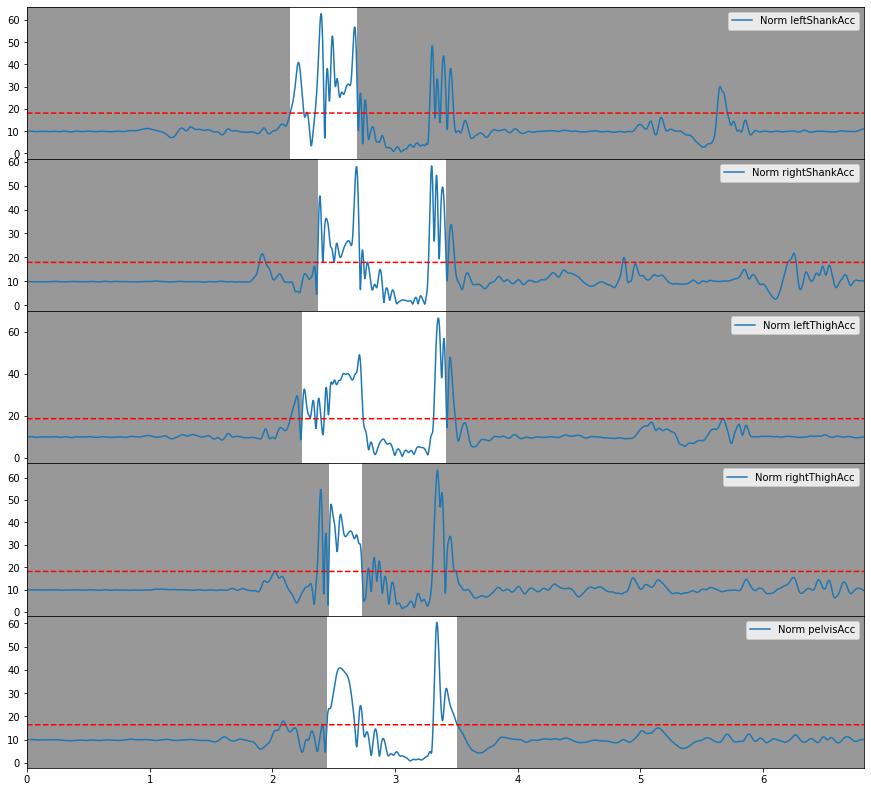

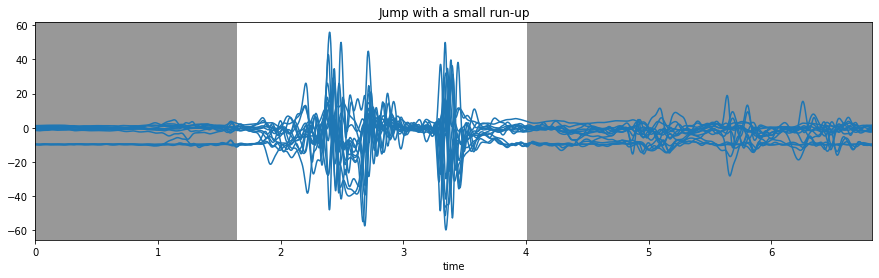

In [120]:
## Example of procedure

# Choose random recording
example = random.choice(glob.glob("{}*.csv".format(in_dir)))
df = pd.read_csv(example)

norms, times, thr = calculate_norms(df, normalize = normalize)
initial, final = times_activity(norms, thr, num_steps = num_steps)

plot_initial_final_timeseries(norms, times, thr, initial, final, plot_thr = True)
show_examples(in_dir, normalize = normalize, filenames = [os.path.split(example)[-1]], margin = margin, num_steps = num_steps)

In [ ]:
## MAIN: Extract activities from all recordings

extracted_activities, samples_activities, times_activities = extract_activities(in_dir, 
                                                                                margin = margin, 
                                                                                only_lengths = True, 
                                                                                num_steps = num_steps, 
                                                                                savefile = savefile)

['C:\\Users\\Rafael\\OneDrive - Delft University of Technology\\Data\\Split\\football_6_38.csv', 'C:\\Users\\Rafael\\OneDrive - Delft University of Technology\\Data\\Split\\football_4_8.csv', 'C:\\Users\\Rafael\\OneDrive - Delft University of Technology\\Data\\Split\\football_3_34.csv', 'C:\\Users\\Rafael\\OneDrive - Delft University of Technology\\Data\\Split\\football_4_19.csv', 'C:\\Users\\Rafael\\OneDrive - Delft University of Technology\\Data\\Split\\football_6_61.csv']


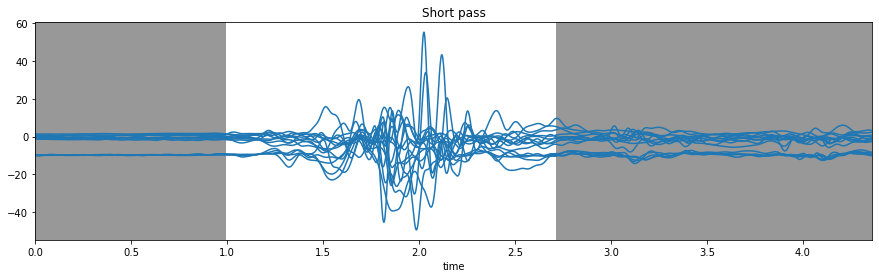

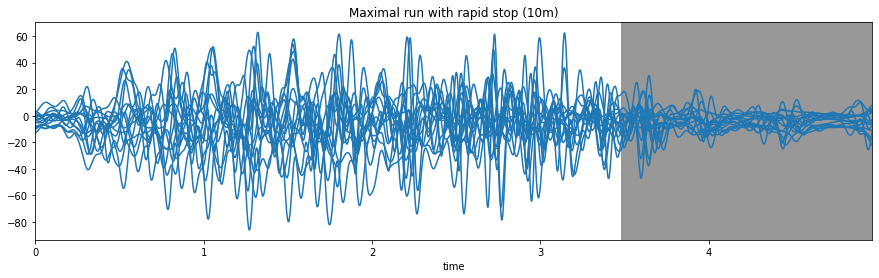

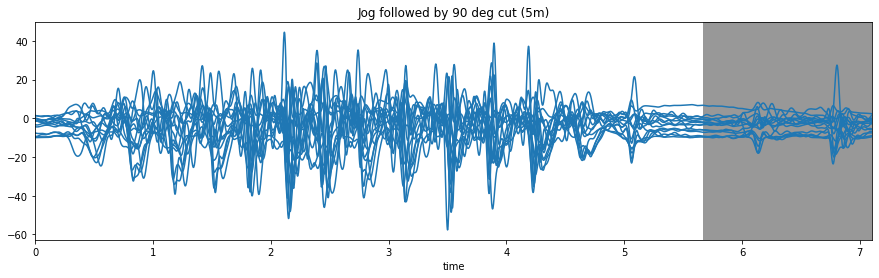

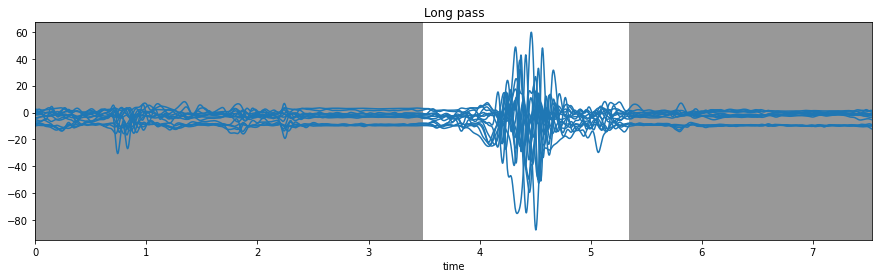

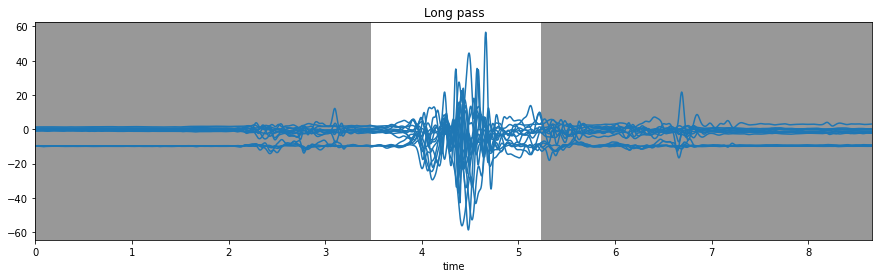

In [80]:
## Show examples of detected activities

random.seed(1)
filenames = None
num_random_examples = 5


show_examples_from_file(in_dir, savefile, filenames = filenames, num_random_examples = num_random_examples)


0/867
100/867
200/867
300/867
400/867
500/867
600/867
700/867
800/867
Done


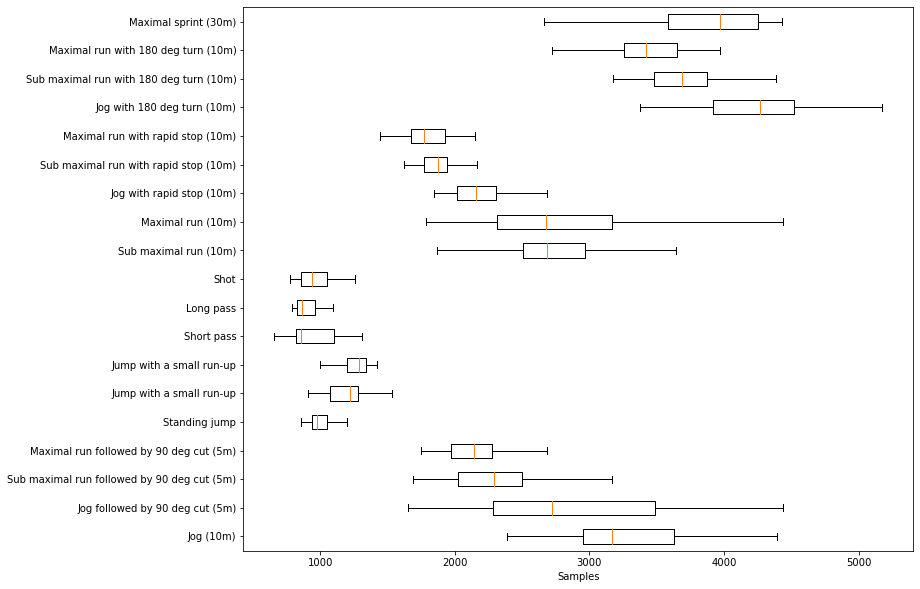

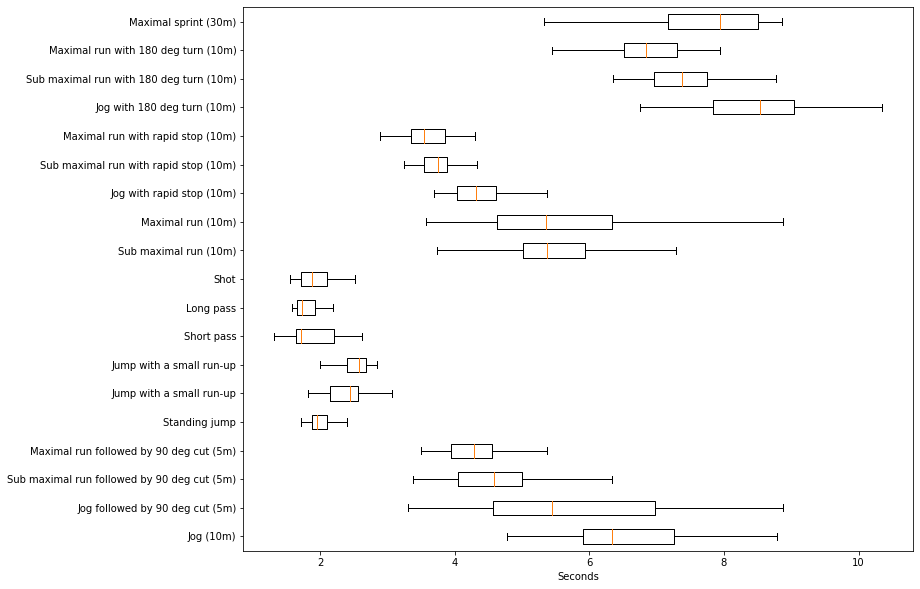

In [34]:
# Boxplots of durations of each class

samples_per_activity, times_per_activity = lengths_per_activity_from_file(in_dir, savefile)

show_outliers = False

# Boxplots of number of timesteps per class
fig = plt.figure(figsize=(12,10))
ax = plt.axes()
ax.boxplot(samples_per_activity.values(), vert = False, showfliers = show_outliers)
ax.set_xlabel('Samples')
ax.set_yticklabels([categories[i] for i in samples_per_activity.keys()]);

# Boxplots of seconds per class
fig = plt.figure(figsize=(12,10))
ax = plt.axes()
ax.boxplot(times_per_activity.values(), vert = False, showfliers = show_outliers)
ax.set_xlabel('Seconds')
ax.set_yticklabels([categories[i] for i in times_per_activity.keys()]);